# Learning Experiment

In [1]:
from draco.learn import linear
from draco.learn import data_util
from draco.run import run
from draco.spec import Task, Query, AspTask, Encoding, Field, Data
from draco.learn.helper import count_violations
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import logging
from vega3 import VegaLite

logging.basicConfig()
logging.getLogger().setLevel(logging.WARN)

In [2]:
data, _ = data_util.load_data(test_size=0)
data = data[data.source != 'manual']

raw_data = data_util.load_neg_pos_specs()

data_yh = data[data.source == 'younghoon'] 
data_bh = data[data.source == 'bahador']

X = data.negative - data.positive
X_yh = data_yh.negative - data_yh.positive
X_bh = data_bh.negative - data_bh.positive

In [3]:
len(data_yh), len(X_yh), len(X_bh), len(data_bh)

(1152, 1152, 10, 10)

In [4]:
X_yh_train, X_yh_test = train_test_split(X_yh, test_size=0.3)
X_bh_train, X_bh_test = train_test_split(X_bh, test_size=0.3)

In [5]:
clf = linear.train_model(pd.concat([X_yh_train, X_bh]), test_size=0.3)
print()
print(clf.score(X, np.ones(len(X))))
print(clf.score(X_yh_test, np.ones(len(X_yh_test))))
print(clf.score(X_bh, np.ones(len(X_bh))))

Train score:  0.9141856392294221
Dev score:  0.9346938775510204

0.9251290877796902
0.9364161849710982
1.0


In [6]:
clf = linear.train_model(X_bh, test_size=0)

clf.score(X_bh, np.ones(len(X_bh)))

Train score:  1.0


1.0

In [7]:
clf = linear.train_model(X_yh_train, test_size=0.3)

clf.score(X_yh_test, np.ones(len(X_yh_test)))

Train score:  0.925531914893617
Dev score:  0.9297520661157025


0.9393063583815029

# Apply a learned model to partial specifications

See whether it comes up with the optimum

In [8]:
clf = linear.train_model(X, test_size=0)

Train score:  0.9294320137693631


In [9]:
weights = clf.coef_[0]
names = X.columns

const_dict = dict(zip(map(lambda x: f'{x}_weight', names), map(int, weights*1000)))

Cost: -499


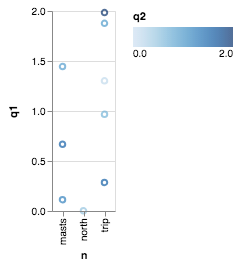

In [10]:
cardinalities = [3, 10, 20]
per_categories = [3, 30]
entropy = [3.9, 0.8]
tasks = ['value', 'summary']

#                      0            1            2            3            4            5
configurations = [(0,0,0,0,0), (1,0,0,0,0), (2,0,0,0,0), (0,1,0,0,0), (0,0,1,0,0), (0,0,0,1,0),
                  (0,0,0,0,1), (1,0,0,0,1), (2,0,0,0,1), (0,1,0,0,1), (0,0,1,0,1), (0,0,0,1,1)]
#                       6           7            8            9           10           11

# cardinality = cardinalities[0]  # 0,1,2
# per_category = per_categories[1]  # 0,1
# entropy_q1 = entropy[1]  # 0,1
# entropy_q2 = entropy[0]  # 0,1
# task = tasks[0]  # 0,1

config = configurations[11]

cardinality = cardinalities[config[0]]  # 0,1,2
per_category = per_categories[config[1]]  # 0,1
entropy_q1 = entropy[config[2]]  # 0,1
entropy_q2 = entropy[config[3]]  # 0,1
task = tasks[config[4]]  # 0,1

data_size = per_category * cardinality
fields = list(map(Field.from_obj, [
    {
      "name": "n",
      "type": "string",
      "entropy": 1,
      "cardinality": cardinality,
      "interesting": task == 'summary'
    },
    {
      "name": "q1",
      "type": "number",
      "entropy": entropy_q1,
      "cardinality": data_size,
      "interesting": True
    },
    {
      "name": "q2",
      "type": "number",
      "entropy": entropy_q2,
      "cardinality": data_size
    }
]))
spec_schema = Data(fields, data_size)
spec_schema.fill_with_random_content()

task = Task(spec_schema,
            Query(
                mark=None,
                encodings=[
                    Encoding(field='q1', ty='quantitative'),
                    Encoding(field='q2', ty='quantitative'),
                    Encoding(field='n', ty='nominal')
                ]),
            task=task
           )

out = run(task,
    constants=const_dict,
    files=['define.lp', 'generate.lp', 'test.lp', 'features.lp', 'weights.lp',
           'assign_weights.lp', 'optimize.lp', 'output.lp', 'younghoon.lp'],
    clear_cache=True
   )

print('Cost:', out.cost)

spec = out.to_vegalite()
VegaLite(spec)

Cost: 989


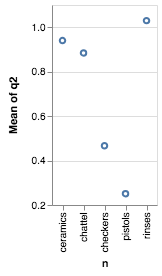

In [12]:
task = 'value'
mark = 'point'

fields = list(map(Field.from_obj, [
    {
      "name": "n",
      "type": "string",
      "cardinality": 9
    },
    {
      "name": "o1",
      "type": "number",
      "cardinality": 25
    },
    {
      "name": "q2",
      "type": "number",
      "cardinality": 407
    }
]))
spec_schema = Data(fields, data_size)
spec_schema.fill_with_random_content()

task = Task(spec_schema,
            Query(
                mark=mark,
                encodings=[
                    Encoding(channel='x', field='n', ty='nominal'),
                    # Encoding(channel='x', field='o1', ty='ordinal'),
                    Encoding(channel='y', field='q2', ty='quantitative'),
                ]),
            task=task
           )

out = run(task,
    constants=const_dict,
    files=['define.lp', 'generate.lp', 'test.lp', 'features.lp', 'weights.lp',
           'assign_weights.lp', 'optimize.lp', 'output.lp', 'bahador.lp'],
    clear_cache=True
   )

print('Cost:', out.cost)

spec = out.to_vegalite()
VegaLite(spec)